Exploration of RISE with image net (the author's own example model)

Function : Exploration of RISE with image net for first verification
Author : Team DIANNA
Contributor :
First Built : 2021.08.25
Last Update : 2021.08.25
Note : We ran the method using the image net model and various images from the internet. Results look as expected. Heatmaps make sense.

In [1]:
import os
import dianna
import onnx
import onnxruntime
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
from dianna import visualization
from dianna.methods import RISE

In [2]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

In [3]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [4]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [5]:
model = Model()

C:\Users\ChristiaanMeijer\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:400: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


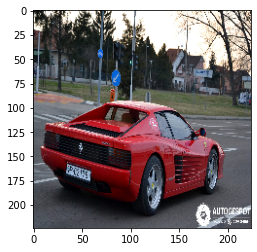

In [21]:
img, x = load_img('ferrari.jpg')
plt.imshow(img)

# Predict classes for test data

Print class and image of a single instance in the test data

In [8]:
# heatmaps = dianna.explain(model.run_on_batch, x, method="RISE", n_masks=2000, feature_res=8)

In [22]:
explainer = RISE(n_masks=600, feature_res=8, p_keep=.5)
heatmaps = explainer(model.run_on_batch, x)

Explaining: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:36<00:00,  6.16s/it]


In [23]:
class_name(np.argmax(model.model.predict([x])))

'sports_car'

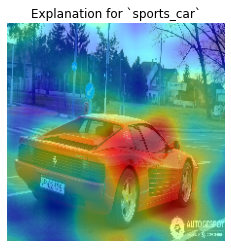

In [24]:
class_idx = np.argmax(model.model.predict([x]))
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(heatmaps[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

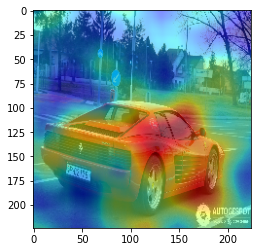

In [25]:
visualization.plot_image(heatmaps[class_idx], image.img_to_array(img)/255., heatmap_cmap='jet')
# visualization.plot_image(heatmaps[class_idx], heatmap_cmap='gray')

In [26]:
def describe(arr):
    print('shape:',arr.shape, 'min:',np.min(arr), 'max:',np.max(arr), 'std:',np.std(arr))

describe(heatmaps[class_idx])

shape: (224, 224) min: 0.31756179159520226 max: 0.4104641137721649 std: 0.01894271329046981


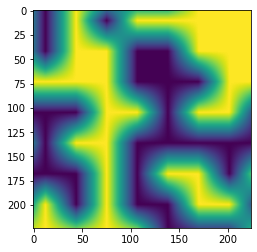

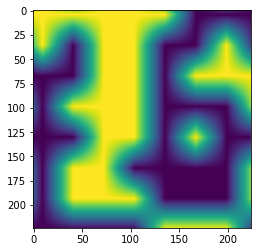

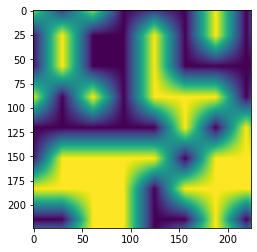

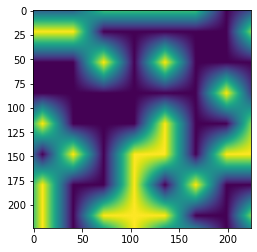

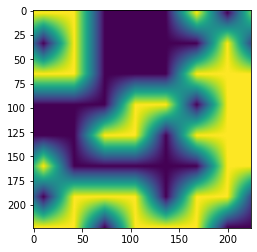

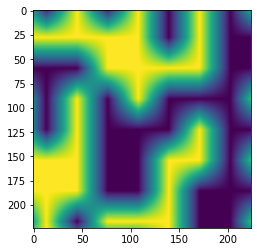

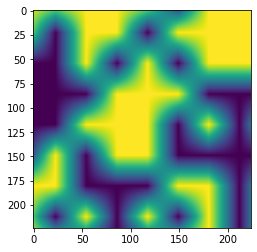

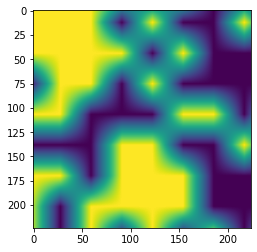

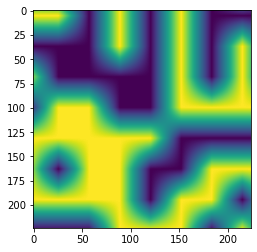

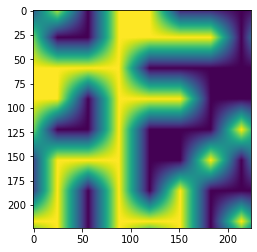

In [27]:
for i in range(10):
    plt.imshow(explainer.masks[i])
    plt.show()